In [1]:
#pip install ee

In [2]:
#pip install geemap

# Import Libraries

In [3]:
import ee
import geemap
import pandas as pd
import numpy as np 
from matplotlib import pyplot
from io import StringIO

#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()

In [4]:
# DOC DATA 
data_doc = pd.read_excel('LTM_Data_2023_3_9.xlsx', usecols=['DOC_MG_L','SITE_ID', 'DATE_SMP'])

# Read the "Site Information" Excel sheet to get the mapping between lake names and SITE_ID
site_info_df = pd.read_excel('Site_Information_2022_8_1 (2).xlsx', usecols=['SITE_ID', 'PROGRAM_ID', 'LAKE_DEPTH_MEAN', 'SITE_NAME'])


# PROF. Coordinates 
data_path = 'ALTM-50-stations.xlsx'
df_lake_info = pd.read_excel(data_path, sheet_name='updated station coordinates', usecols=['SITE_ID', 'SITE_NAME','LATDD_CENT', 'LONDD_CENT'])


merge_data = pd.merge(data_doc, site_info_df, on='SITE_ID')
merge_data = pd.merge(merge_data, df_lake_info, on= ['SITE_ID', 'SITE_NAME'])

data_modify = merge_data[merge_data['PROGRAM_ID']=='LTM_ALTM']

In [5]:
data_modify

,SITE_ID,DATE_SMP,DOC_MG_L,PROGRAM_ID,SITE_NAME,LAKE_DEPTH_MEAN,LATDD_CENT,LONDD_CENT
0,040850,1997-09-22,3.100000,LTM_ALTM,Squaw Lake,3.4,43.63276,-74.73863
2,040850,1995-03-02,3.031000,LTM_ALTM,Squaw Lake,3.4,43.63276,-74.73863
4,040850,1996-08-19,3.595000,LTM_ALTM,Squaw Lake,3.4,43.63276,-74.73863
6,040850,2003-11-06,4.232000,LTM_ALTM,Squaw Lake,3.4,43.63276,-74.73863
8,040850,2005-07-11,3.344000,LTM_ALTM,Squaw Lake,3.4,43.63276,-74.73863
...,...,...,...,...,...,...,...,...
17863,1A3-048,2011-05-18,4.283944,LTM_ALTM,Grass Pond,1.5,43.69207,-75.06172
17864,1A3-048,2015-06-10,5.509394,LTM_ALTM,Grass Pond,1.5,43.69207,-75.06172
17865,1A3-048,2016-07-14,4.884900,LTM_ALTM,Grass Pond,1.5,43.69207,-75.06172
17866,1A3-048,2016-09-15,6.344000,LTM_ALTM,Grass Pond,1.5,43.69207,-75.06172


# REFLECTANCE data prep

In [6]:
import ee
import geemap
import pandas as pd
import numpy as np 
from matplotlib import pyplot
from io import StringIO


Map= geemap.Map()

# Authenticate and initialize the Earth Engine API
#ee.Authenticate()  # Only needed for the first time
ee.Initialize()

# Create a list of lake names
lake_names = [
    'Little Hope Pond', 'Big Hope Pond', 'East Copperas Pond', 'Sunday Pond', 'Sochia Pond',
    'Grass Pond (3)', 'Little Clear Pond', 'Loon Hollow Pond', 'Willys Lake', 'Woods Lake',
    'Middle Settlement Lake', 'Middle Branch Lake', 'Limekiln Lake', 'Squaw Lake', 'Indian Lake',
    'Brook Trout Lake', 'Lost Pond', 'North Lake', 'Willis Lake', 'Long Pond', 'Carry Pond',
    'Lake Colden', 'Avalanche Lake', 'Little Simon Pond', 'Raquette Lake Reservoir', 'G Lake',
    'Constable Pond', 'Middle Pond', 'Arbutus Pond', 'Sagamore Lake', 'Black Pond', 'Windfall Pond',
    'Queer Lake', 'Heart Lake', 'Big Moose Lake', 'Cascade Lake', 'Dart Lake', 'Little Echo Pond',
    'Moss Lake', 'Lake Rondaxe', 'Squash Pond', 'West Pond', 'Owen Pond', 'Jockeybush Lake',
    'Barnes Lake', 'Clear Pond', 'Otter Lake', 'Nate Pond', 'Grass Pond', 'South Lake (East Branch)'
]
# sentinel2_bands =['B1','B2','B3','B4','B5','B6','B8','B8A','B11']
# STD_NAMES = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1','RedEdge2','RedEdge4','NIR','SWIR1']

sentinel2_bands =['B1','B2','B3','B4','B5','B6','QA60','B8A','B11']
STD_NAMES = ['Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1','RedEdge2','Cloud','NIR','SWIR1']

# Define the function to mask clouds and cloud shadows from Landsat 5 surface reflectance imagery
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11

    # Create the cloud mask
    cloudMask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    # Apply the cloud mask to the image
    maskedImage = image.updateMask(cloudMask)

    return maskedImage


# Define the function to compute the mean reflectance values for the specified bands within the region of interest (lake)
def reflectance(img, lake):
    reflectance_values = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=lake, scale=30).select(STD_NAMES)
    return img.set('DATE_SMP', img.date().format()).set('reflectance', reflectance_values)

# Initialize an empty list to store the dataframes for each lake
dfs = []

# Create a dictionary to map each lake name to a numerical label
lake_name_to_label = {lake_name: i for i, lake_name in enumerate(lake_names)}

# Loop through each lake name and retrieve Landsat 5 imagery for that lake
for SITE_NAME in lake_names:
    # Retrieve Landsat 5 imagery for the specific lake
    lake = ee.FeatureCollection('projects/ee-touhedakhanom14/assets/stations-coord')\
        .filter(ee.Filter.eq('SITE_NAME', SITE_NAME))
    

    Map.addLayer(lake, {'color': 'red'})  # Adding the original point to show the difference

    
    
    s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filter(ee.Filter.calendarRange(2019, 2023, 'year')) \
    .map(maskS2clouds) \
    .select(sentinel2_bands, STD_NAMES)\
    .filterBounds(lake) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))

    # Map the reflectance function over the Landsat 5 ImageCollection for the specific lake
    map_reflectance = s2.map(lambda img: reflectance(img, lake))

    # Reduce the mapped image collection to get reflectance values for the specific lake
    list_reflectance = map_reflectance.reduceColumns(ee.Reducer.toList(2), ['DATE_SMP', 'reflectance']).values().get(0)

    # Convert the results to a pandas DataFrame
    df_reflectance = pd.DataFrame(list_reflectance.getInfo(), columns=['DATE_SMP', 'reflectance'])
    df_reflectance['DATE_SMP'] = pd.to_datetime(df_reflectance['DATE_SMP'])
    df_reflectance['DATE_SMP'] = df_reflectance['DATE_SMP'].dt.date
    df_reflectance['reflectance'] = df_reflectance['reflectance'].apply(lambda x: {k: v/10000 for k, v in x.items() if v is not None})

    # Unpack the 'reflectance' dictionary and create separate columns for each band
    df_reflectance = pd.concat([df_reflectance.drop('reflectance', axis=1),
                                df_reflectance['reflectance'].apply(pd.Series).astype('float64', errors='ignore')], axis=1)

    # Add a new column for the lake name
    df_reflectance['SITE_NAME'] = SITE_NAME
    
    # Add a new column for the lake label (numeric representation)
    df_reflectance['LAKE_LABEL'] = lake_name_to_label[SITE_NAME]

    # Add the DataFrame to the list
    dfs.append(df_reflectance)

# Concatenate all DataFrames into a single DataFrame
df_all_lakes = pd.concat(dfs, ignore_index=True)

# Sort the DataFrame by 'DATE_SMP' in ascending order
df_all_lakes.sort_values(by='DATE_SMP', inplace=True)


Map.centerObject(lake, 10)
Map
# Display the DataFrame containing reflectance values for all lakes with separate columns for each lake
# print(df_all_lakes)


Map(center=[43.50986135214135, -74.8826739109505], controls=(WidgetControl(options=['position', 'transparent_b…

In [7]:
df_all_lakes

,DATE_SMP,Aerosols,Blue,Cloud,Green,NIR,Red,RedEdge1,RedEdge2,SWIR1,SITE_NAME,LAKE_LABEL
756,2019-01-04,0.8181,0.8262,0.0,0.7607,0.5595,0.6992,0.6896,0.6426,0.0711,Loon Hollow Pond,7
5850,2019-01-04,0.8717,0.9142,0.0,0.9262,0.8625,0.9248,0.9573,0.9199,0.0639,Barnes Lake,44
4841,2019-01-11,0.7205,0.7277,0.0,0.6671,0.5938,0.6506,0.6407,0.6310,0.1581,Lake Rondaxe,39
6544,2019-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Lake (East Branch),49
6081,2019-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Clear Pond,45
...,...,...,...,...,...,...,...,...,...,...,...,...
2969,2023-07-19,0.7793,0.7946,0.0,0.7662,0.7770,0.7610,0.8050,0.7977,0.6700,Avalanche Lake,22
968,2023-07-22,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Loon Hollow Pond,7
6079,2023-07-22,0.1558,0.1596,0.0,0.1640,0.1660,0.1589,0.1660,0.1674,0.1546,Barnes Lake,44
969,2023-08-01,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Loon Hollow Pond,7


In [8]:
df_all_lakes.dropna(inplace=True)


In [9]:
df_all_lakes

,DATE_SMP,Aerosols,Blue,Cloud,Green,NIR,Red,RedEdge1,RedEdge2,SWIR1,SITE_NAME,LAKE_LABEL
756,2019-01-04,0.8181,0.8262,0.0,0.7607,0.5595,0.6992,0.6896,0.6426,0.0711,Loon Hollow Pond,7
5850,2019-01-04,0.8717,0.9142,0.0,0.9262,0.8625,0.9248,0.9573,0.9199,0.0639,Barnes Lake,44
4841,2019-01-11,0.7205,0.7277,0.0,0.6671,0.5938,0.6506,0.6407,0.6310,0.1581,Lake Rondaxe,39
2857,2019-01-11,0.1862,0.1273,0.0,0.0863,0.0373,0.0550,0.0328,0.0622,0.0049,Avalanche Lake,22
6319,2019-01-11,0.4772,0.8468,0.0,0.8359,0.8590,0.8563,0.9075,0.8903,0.1668,Nate Pond,47
...,...,...,...,...,...,...,...,...,...,...,...,...
5613,2023-07-19,1.0965,1.0982,0.0,1.0580,1.0159,1.0544,1.1112,1.0667,0.7273,Owen Pond,42
2413,2023-07-19,0.1237,0.1279,0.0,0.1313,0.1644,0.1358,0.1404,0.1473,0.1759,North Lake,17
2969,2023-07-19,0.7793,0.7946,0.0,0.7662,0.7770,0.7610,0.8050,0.7977,0.6700,Avalanche Lake,22
6079,2023-07-22,0.1558,0.1596,0.0,0.1640,0.1660,0.1589,0.1660,0.1674,0.1546,Barnes Lake,44


In [10]:
pd.set_option('display.max_rows', None)
print(df_all_lakes)

        DATE_SMP  Aerosols    Blue  Cloud   Green     NIR     Red  RedEdge1  \
756   2019-01-04    0.8181  0.8262    0.0  0.7607  0.5595  0.6992    0.6896   
5850  2019-01-04    0.8717  0.9142    0.0  0.9262  0.8625  0.9248    0.9573   
4841  2019-01-11    0.7205  0.7277    0.0  0.6671  0.5938  0.6506    0.6407   
2857  2019-01-11    0.1862  0.1273    0.0  0.0863  0.0373  0.0550    0.0328   
6319  2019-01-11    0.4772  0.8468    0.0  0.8359  0.8590  0.8563    0.9075   
5284  2019-01-11    0.5388  0.6845    0.0  0.6699  0.6771  0.6757    0.6511   
5285  2019-01-11    0.4817  0.6191    0.0  0.6077  0.6296  0.6183    0.5998   
2524  2019-01-11    0.4257  0.5577    0.0  0.5187  0.4813  0.4875    0.5089   
2634  2019-01-11    0.8566  0.9119    0.0  0.8891  0.8547  0.9091    0.9160   
5851  2019-01-11    1.1755  1.1942    0.0  1.1628  1.0551  1.1614    1.1546   
5615  2019-01-11    0.3128  0.2223    0.0  0.1727  0.1826  0.1479    0.1472   
5614  2019-01-11    0.3255  0.2270    0.0  0.1744  0

In [11]:
df_all_lakes['DATE_SMP'] = pd.to_datetime(df_all_lakes['DATE_SMP'])
data_modify['DATE_SMP'] = pd.to_datetime(data_modify['DATE_SMP'])

In [12]:
data_modify.sort_values('DATE_SMP', inplace=True)
df_all_lakes.sort_values('DATE_SMP', inplace=True)


In [13]:
# Create the 3-day time window
window_size = pd.Timedelta(days=3)

# Merge data within the 3-day time window
merged_data = pd.merge_asof(data_modify, df_all_lakes, on='DATE_SMP', by='SITE_NAME', tolerance=window_size)
merged_data = merged_data.dropna(subset=['Blue'])
merged_data = merged_data.dropna(subset=['LAKE_DEPTH_MEAN'])
merged_data

,SITE_ID,DATE_SMP,DOC_MG_L,PROGRAM_ID,SITE_NAME,LAKE_DEPTH_MEAN,LATDD_CENT,LONDD_CENT,Aerosols,Blue,Cloud,Green,NIR,Red,RedEdge1,RedEdge2,SWIR1,LAKE_LABEL
15284,040186,2019-02-28,8.126200,LTM_ALTM,Loon Hollow Pond,3.4,43.96292,-75.04305,1.2071,1.1988,0.0,1.1221,1.0054,1.1152,1.1127,1.0845,0.1499,7.0
15291,1A3-065,2019-04-01,4.190400,LTM_ALTM,South Lake (East Branch),8.3,43.51165,-74.88815,0.6755,1.0456,0.0,1.0393,0.9754,1.0628,1.0771,1.0456,0.1452,49.0
15295,1A1-112,2019-04-03,7.457600,LTM_ALTM,West Pond,1.5,43.81102,-74.87937,0.5512,0.6703,0.0,0.6905,0.7846,0.6995,0.7467,0.7533,0.1494,41.0
15304,040186,2019-04-04,8.023800,LTM_ALTM,Loon Hollow Pond,3.4,43.96292,-75.04305,0.9155,0.9114,0.0,0.8678,0.7803,0.8702,0.8766,0.8547,0.0270,7.0
15318,1A2-077,2019-04-16,4.902200,LTM_ALTM,Clear Pond,9.2,43.99719,-73.82435,0.4859,0.6954,0.0,0.6822,0.5689,0.6720,0.6900,0.6555,0.0317,45.0
15319,1A1-105,2019-04-17,5.148900,LTM_ALTM,Cascade Lake,4.2,43.79039,-74.80236,0.4133,0.3416,0.0,0.3379,0.1577,0.3174,0.3111,0.2495,0.0222,35.0
15329,050706,2019-05-06,5.574700,LTM_ALTM,Lake Colden,2.3,44.12266,-73.97953,0.0237,0.0186,0.0,0.0184,0.0317,0.0154,0.0185,0.0239,0.0185,21.0
15330,1A1-102,2019-05-06,2.644700,LTM_ALTM,Heart Lake,5.1,44.18229,-73.96920,0.0324,0.0280,0.0,0.0314,0.0152,0.0204,0.0158,0.0061,0.0195,33.0
15331,050707,2019-05-06,6.453600,LTM_ALTM,Avalanche Lake,3.3,44.13287,-73.96681,0.0534,0.0532,0.0,0.0589,0.2383,0.0589,0.0852,0.1667,0.1023,22.0
15338,1A1-105,2019-05-09,4.361700,LTM_ALTM,Cascade Lake,4.2,43.79039,-74.80236,0.0301,0.0212,0.0,0.0180,0.0098,0.0122,0.0114,0.0090,0.0146,35.0


# Error

In [14]:
# num_rows, num_cols = X.shape
# print("Number of rows:", num_rows)
# print("Number of columns:", num_cols)

In [15]:
#pip install xgboost


In [16]:
#pip install lightgbm

In [17]:
# # Preparing the training data
# X = merged_data[['LAKE_LABEL','Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1','RedEdge2','Cloud','NIR','SWIR1','LAKE_DEPTH_MEAN']]  # Features
# y = merged_data['DOC_MG_L']  # Target variable


# WITHOUT LAKE LABEL AS FEATURES 3 day window/n

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Preparing the training data
X = merged_data[['Blue', 'Green', 'Red','LAKE_DEPTH_MEAN']]  # Features
y = merged_data['DOC_MG_L']  # Target variable

# Group the data by 'LAKE_LABEL'
grouped_data = merged_data.groupby('LAKE_LABEL')

# Initialize lists to store the training and testing data for all lakes
X_train_all, X_test_all, y_train_all, y_test_all = [], [], [], []

# Loop through each lake group and split data into training and testing sets
for _, lake_group in grouped_data:
    if len(lake_group) < 2:
        # Skip this lake group as it has insufficient data for splitting
        continue
    X_lake = lake_group[['Blue', 'Green', 'Red','LAKE_DEPTH_MEAN']]
    y_lake = lake_group['DOC_MG_L']
   
    # Split data into training and testing sets for the current lake
    X_train_lake, X_test_lake, y_train_lake, y_test_lake = train_test_split(X_lake, y_lake, test_size=0.3, random_state=42)
   
    # Append the data for the current lake to the corresponding lists
    X_train_all.append(X_train_lake)
    X_test_all.append(X_test_lake)
    y_train_all.append(y_train_lake)
    y_test_all.append(y_test_lake)

# Concatenate the training and testing data for all lakes
X_train = pd.concat(X_train_all)
X_test = pd.concat(X_test_all)
y_train = pd.concat(y_train_all)
y_test = pd.concat(y_test_all)

print('**************Data Points Used***************************')
num_rows, num_cols = X.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

# Initialize models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'MLPRegressor': MLPRegressor(random_state=42)
}

# Initialize lists to store model evaluation results
model_names, r2_scores, mses, rmses, maes = [], [], [], [], []

# Train and evaluate each model
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Predict DOC values for the testing data
    y_pred = model.predict(X_test)

    # Create DataFrames for the training and testing data with all bands and the predicted values
    data_train = X_train.copy()
    data_train['original_DOC'] = y_train
    data_train['predicted_DOC'] = model.predict(X_train)

    data_test = X_test.copy()
    data_test['original_DOC'] = y_test
    data_test['predicted_DOC'] = y_pred

    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)

    # Append the results to the lists
    model_names.append(model_name)
    r2_scores.append(r2)
    mses.append(mse)
    rmses.append(rmse)
    maes.append(mae)

# Display the predicted DOC values for the training and testing data
print(f'*************Predicted Training data ({model_name})***************')
print(data_train)

print(f'*************Predicted Testing data ({model_name})***************')
print(data_test)

# Create a dataframe to store the results
evaluation_df_WITHOUT3 = pd.DataFrame({
    'Model': model_names,
    'R^2': r2_scores,
    'MSE': mses,
    'RMSE': rmses,
    'MAE': maes
})

# Print the dataframe
print('# WITHOUT LAKE LABEL AS FEATURES 3 day window/n')
print(evaluation_df_WITHOUT3)

**************Data Points Used***************************
Number of rows: 121
Number of columns: 4
*************Predicted Training data (MLPRegressor)***************
         Blue   Green     Red  LAKE_DEPTH_MEAN  original_DOC  predicted_DOC
15500  1.0430  1.0157  1.0100              5.8      9.131399      10.098920
15692  0.0060  0.0026  0.0031              5.8      7.907400       5.575988
15347  0.0087  0.0074  0.0050              4.1      9.624900       4.627261
15488  0.7896  0.7686  0.7819              4.1     12.015331       8.064275
15655  1.0957  1.0599  1.0579              5.5      7.474600      10.141437
15443  0.0083  0.0059  0.0033              5.5      7.496900       5.414417
15691  0.0092  0.0080  0.0073              5.5      6.702900       5.424760
15284  1.1988  1.1221  1.1152              3.4      8.126200       9.159924
15433  0.0102  0.0114  0.0066              3.4      5.749400       4.241036
15541  0.0372  0.0348  0.0279              6.1      4.779552       5.87615

In [19]:
#evaluation_df_WITHOUT3.to_excel(r'/Users/touhedakhanom/Downloads/NSF SUMMER Research /Research /Machine Learning/ML/EXCEL SURFACE REFLECTANCE\SR WITHOUT LAKE LABEL AS FEATURES 3 day window.xlsx', index=False)


# WITH LAKE FEATURE AS 3 DAY WINDOW

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler


# Preparing the training data
X = merged_data[['LAKE_LABEL','Blue', 'Green', 'Red','LAKE_DEPTH_MEAN']]  # Features
y = merged_data['DOC_MG_L']  # Target variable

# Group the data by 'LAKE_LABEL'
grouped_data = merged_data.groupby('LAKE_LABEL')

# Initialize lists to store the training and testing data for all lakes
X_train_all, X_test_all, y_train_all, y_test_all = [], [], [], []

# Loop through each lake group and split data into training and testing sets
for _, lake_group in grouped_data:
    if len(lake_group) < 2:
        # Skip this lake group as it has insufficient data for splitting
        continue
    X_lake = lake_group[['LAKE_LABEL','Blue', 'Green', 'Red', 'LAKE_DEPTH_MEAN']]
    y_lake = lake_group['DOC_MG_L']
   
    # Split data into training and testing sets for the current lake
    X_train_lake, X_test_lake, y_train_lake, y_test_lake = train_test_split(X_lake, y_lake, test_size=0.3, random_state=42)
   
    # Append the data for the current lake to the corresponding lists
    X_train_all.append(X_train_lake)
    X_test_all.append(X_test_lake)
    y_train_all.append(y_train_lake)
    y_test_all.append(y_test_lake)

# Concatenate the training and testing data for all lakes
X_train = pd.concat(X_train_all)
X_test = pd.concat(X_test_all)
y_train = pd.concat(y_train_all)
y_test = pd.concat(y_test_all)




print('**************Data Points Used***************************')
num_rows, num_cols = X.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)



# Initialize models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'MLPRegressor': MLPRegressor(random_state=42)
}

# Initialize lists to store model evaluation results
model_names, r2_scores, mses, rmses, maes = [], [], [], [], []

# Train and evaluate each model
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Predict DOC values for the testing data
    y_pred = model.predict(X_test)

    # Create DataFrames for the training and testing data with all bands and the predicted values
    data_train = X_train.copy()
    data_train['original_DOC'] = y_train
    data_train['predicted_DOC'] = model.predict(X_train)

    data_test = X_test.copy()
    data_test['original_DOC'] = y_test
    data_test['predicted_DOC'] = y_pred

    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)

    # Append the results to the lists
    model_names.append(model_name)
    r2_scores.append(r2)
    mses.append(mse)
    rmses.append(rmse)
    maes.append(mae)

# Display the predicted DOC values for the training and testing data
print(f'*************Predicted Training data ({model_name})***************')
print(data_train)

print(f'*************Predicted Testing data ({model_name})***************')
print(data_test)

# Create a dataframe to store the results
evaluation_df_WITH3 = pd.DataFrame({
    'Model': model_names,
    'R^2': r2_scores,
    'MSE': mses,
    'RMSE': rmses,
    'MAE': maes
})

# Print the dataframe
print('# WITH LAKE LABEL AS FEATURES 3 day window/n')
print(evaluation_df_WITH3)

**************Data Points Used***************************
Number of rows: 121
Number of columns: 5
*************Predicted Training data (MLPRegressor)***************
       LAKE_LABEL    Blue   Green     Red  LAKE_DEPTH_MEAN  original_DOC  \
15500         1.0  1.0430  1.0157  1.0100              5.8      9.131399   
15692         1.0  0.0060  0.0026  0.0031              5.8      7.907400   
15347         2.0  0.0087  0.0074  0.0050              4.1      9.624900   
15488         2.0  0.7896  0.7686  0.7819              4.1     12.015331   
15655         6.0  1.0957  1.0599  1.0579              5.5      7.474600   
15443         6.0  0.0083  0.0059  0.0033              5.5      7.496900   
15691         6.0  0.0092  0.0080  0.0073              5.5      6.702900   
15284         7.0  1.1988  1.1221  1.1152              3.4      8.126200   
15433         7.0  0.0102  0.0114  0.0066              3.4      5.749400   
15541        12.0  0.0372  0.0348  0.0279              6.1      4.779552  

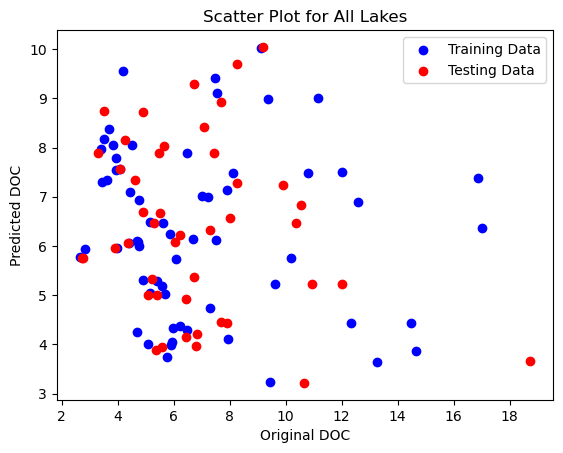

In [21]:
# Plot the scatter plot for all lakes combined
plt.scatter( data_train['original_DOC'],data_train['predicted_DOC'], color='blue', label='Training Data')
plt.scatter(data_test['original_DOC'],data_test['predicted_DOC'],  color='red', label='Testing Data')

# Set plot title and labels
plt.title('Scatter Plot for All Lakes')
plt.xlabel('Original DOC')
plt.ylabel('Predicted DOC')
plt.legend()

# Show the plot
plt.show()

In [22]:
#evaluation_df_WITH3.to_excel(r'/Users/touhedakhanom/Downloads/NSF SUMMER Research /Research /Machine Learning/ML/EXCEL SURFACE REFLECTANCE\SR WITH LAKE LABEL AS FEATURES 3 day window.xlsx', index=False)


# WITHOUT LAKE LABEL AS FEATURES 1 day window/n


In [23]:
# Create the 3-day time window
window_size = pd.Timedelta(days=1)

# Merge data within the 3-day time window
merged_data_1 = pd.merge_asof(data_modify, df_all_lakes, on='DATE_SMP', by='SITE_NAME', tolerance=window_size)
merged_data_1 = merged_data_1.dropna(subset=['Blue'])
merged_data_1 = merged_data_1.dropna(subset=['LAKE_DEPTH_MEAN'])
merged_data_1

,SITE_ID,DATE_SMP,DOC_MG_L,PROGRAM_ID,SITE_NAME,LAKE_DEPTH_MEAN,LATDD_CENT,LONDD_CENT,Aerosols,Blue,Cloud,Green,NIR,Red,RedEdge1,RedEdge2,SWIR1,LAKE_LABEL
15284,040186,2019-02-28,8.126200,LTM_ALTM,Loon Hollow Pond,3.4,43.96292,-75.04305,1.2071,1.1988,0.0,1.1221,1.0054,1.1152,1.1127,1.0845,0.1499,7.0
15291,1A3-065,2019-04-01,4.190400,LTM_ALTM,South Lake (East Branch),8.3,43.51165,-74.88815,0.6755,1.0456,0.0,1.0393,0.9754,1.0628,1.0771,1.0456,0.1452,49.0
15304,040186,2019-04-04,8.023800,LTM_ALTM,Loon Hollow Pond,3.4,43.96292,-75.04305,0.9155,0.9114,0.0,0.8678,0.7803,0.8702,0.8766,0.8547,0.0270,7.0
15318,1A2-077,2019-04-16,4.902200,LTM_ALTM,Clear Pond,9.2,43.99719,-73.82435,0.4859,0.6954,0.0,0.6822,0.5689,0.6720,0.6900,0.6555,0.0317,45.0
15319,1A1-105,2019-04-17,5.148900,LTM_ALTM,Cascade Lake,4.2,43.79039,-74.80236,0.4133,0.3416,0.0,0.3379,0.1577,0.3174,0.3111,0.2495,0.0222,35.0
15329,050706,2019-05-06,5.574700,LTM_ALTM,Lake Colden,2.3,44.12266,-73.97953,0.0237,0.0186,0.0,0.0184,0.0317,0.0154,0.0185,0.0239,0.0185,21.0
15330,1A1-102,2019-05-06,2.644700,LTM_ALTM,Heart Lake,5.1,44.18229,-73.96920,0.0324,0.0280,0.0,0.0314,0.0152,0.0204,0.0158,0.0061,0.0195,33.0
15331,050707,2019-05-06,6.453600,LTM_ALTM,Avalanche Lake,3.3,44.13287,-73.96681,0.0534,0.0532,0.0,0.0589,0.2383,0.0589,0.0852,0.1667,0.1023,22.0
15346,1A1-107,2019-05-16,10.358000,LTM_ALTM,Little Echo Pond,2.9,44.30849,-74.35564,0.0709,0.0878,0.0,0.0879,0.1183,0.0854,0.0974,0.1133,0.1143,37.0
15347,020138,2019-05-16,9.624900,LTM_ALTM,East Copperas Pond,4.1,44.31395,-74.37624,0.0233,0.0087,0.0,0.0074,0.0118,0.0050,0.0067,0.0102,0.0205,2.0


In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Preparing the training data
X = merged_data_1[['Blue', 'Green', 'Red','LAKE_DEPTH_MEAN']]  # Features
y = merged_data_1['DOC_MG_L']  # Target variable

# Group the data by 'LAKE_LABEL'
grouped_data = merged_data_1.groupby('LAKE_LABEL')

# Initialize lists to store the training and testing data for all lakes
X_train_all, X_test_all, y_train_all, y_test_all = [], [], [], []

# Loop through each lake group and split data into training and testing sets
for _, lake_group in grouped_data:
    if len(lake_group) < 4: #Give me 0.3 but this is better 
        # Skip this lake group as it has insufficient data for splitting
        continue
    X_lake = lake_group[['Blue', 'Green', 'Red','LAKE_DEPTH_MEAN']]
    y_lake = lake_group['DOC_MG_L']
   
    # Split data into training and testing sets for the current lake
    X_train_lake, X_test_lake, y_train_lake, y_test_lake = train_test_split(X_lake, y_lake, test_size=0.3, random_state=42)
   
    # Append the data for the current lake to the corresponding lists
    X_train_all.append(X_train_lake)
    X_test_all.append(X_test_lake)
    y_train_all.append(y_train_lake)
    y_test_all.append(y_test_lake)

# Concatenate the training and testing data for all lakes
X_train = pd.concat(X_train_all)
X_test = pd.concat(X_test_all)
y_train = pd.concat(y_train_all)
y_test = pd.concat(y_test_all)

print('**************Data Points Used***************************')
num_rows, num_cols = X.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

# Initialize models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'MLPRegressor': MLPRegressor(random_state=42)
}

# Initialize lists to store model evaluation results
model_names, r2_scores, mses, rmses, maes = [], [], [], [], []

# Train and evaluate each model
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Predict DOC values for the testing data
    y_pred = model.predict(X_test)

    # Create DataFrames for the training and testing data with all bands and the predicted values
    data_train = X_train.copy()
    data_train['original_DOC'] = y_train
    data_train['predicted_DOC'] = model.predict(X_train)

    data_test = X_test.copy()
    data_test['original_DOC'] = y_test
    data_test['predicted_DOC'] = y_pred

    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)

    # Append the results to the lists
    model_names.append(model_name)
    r2_scores.append(r2)
    mses.append(mse)
    rmses.append(rmse)
    maes.append(mae)

# Display the predicted DOC values for the training and testing data
print(f'*************Predicted Training data ({model_name})***************')
print(data_train)

print(f'*************Predicted Testing data ({model_name})***************')
print(data_test)

# Create a dataframe to store the results
evaluation_df_WITHOUT1 = pd.DataFrame({
    'Model': model_names,
    'R^2': r2_scores,
    'MSE': mses,
    'RMSE': rmses,
    'MAE': maes
})

# Print the dataframe
print('# WITHOUT LAKE LABEL AS FEATURES 1 day window/n')
print(evaluation_df_WITHOUT1)

**************Data Points Used***************************
Number of rows: 58
Number of columns: 4
*************Predicted Training data (MLPRegressor)***************
         Blue   Green     Red  LAKE_DEPTH_MEAN  original_DOC  predicted_DOC
15347  0.0087  0.0074  0.0050              4.1      9.624900       3.779854
15488  0.7896  0.7686  0.7819              4.1     12.015331       6.546094
15284  1.1988  1.1221  1.1152              3.4      8.126200       7.240465
15433  0.0102  0.0114  0.0066              3.4      5.749400       3.355513
15318  0.6954  0.6822  0.6720              9.2      4.902200       9.349954
15440  0.0108  0.0151  0.0077              9.2      4.099900       6.947309
*************Predicted Testing data (MLPRegressor)***************
         Blue   Green     Red  LAKE_DEPTH_MEAN  original_DOC  predicted_DOC
15442  0.0067  0.0073  0.0056              4.1     10.955500       3.777835
15509  0.0078  0.0072  0.0070              4.1     12.007031       3.780842
15304  0.

In [25]:
#evaluation_df_WITHOUT1.to_excel(r'/Users/touhedakhanom/Downloads/NSF SUMMER Research /Research /Machine Learning/ML/EXCEL SURFACE REFLECTANCE\SR WITHOUT LAKE LABEL AS FEATURES 1 day window.xlsx', index=False)


# WITH LAKE LABEL AS FEATURES 1 day window/n


In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler


# Preparing the training data
X = merged_data_1[['LAKE_LABEL','Blue', 'Green', 'Red','LAKE_DEPTH_MEAN']]  # Features
y = merged_data_1['DOC_MG_L']  # Target variable

# Group the data by 'LAKE_LABEL'
grouped_data = merged_data_1.groupby('LAKE_LABEL')

# Initialize lists to store the training and testing data for all lakes
X_train_all, X_test_all, y_train_all, y_test_all = [], [], [], []

# Loop through each lake group and split data into training and testing sets
for _, lake_group in grouped_data:
    if len(lake_group) < 4:
        # Skip this lake group as it has insufficient data for splitting
        continue
    X_lake = lake_group[['LAKE_LABEL','Blue', 'Green', 'Red', 'LAKE_DEPTH_MEAN']]
    y_lake = lake_group['DOC_MG_L']
   
    # Split data into training and testing sets for the current lake
    X_train_lake, X_test_lake, y_train_lake, y_test_lake = train_test_split(X_lake, y_lake, test_size=0.3, random_state=42)
   
    # Append the data for the current lake to the corresponding lists
    X_train_all.append(X_train_lake)
    X_test_all.append(X_test_lake)
    y_train_all.append(y_train_lake)
    y_test_all.append(y_test_lake)

# Concatenate the training and testing data for all lakes
X_train = pd.concat(X_train_all)
X_test = pd.concat(X_test_all)
y_train = pd.concat(y_train_all)
y_test = pd.concat(y_test_all)




print('**************Data Points Used***************************')
num_rows, num_cols = X.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)



# Initialize models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'MLPRegressor': MLPRegressor(random_state=42)
}

# Initialize lists to store model evaluation results
model_names, r2_scores, mses, rmses, maes = [], [], [], [], []

# Train and evaluate each model
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Predict DOC values for the testing data
    y_pred = model.predict(X_test)

    # Create DataFrames for the training and testing data with all bands and the predicted values
    data_train = X_train.copy()
    data_train['original_DOC'] = y_train
    data_train['predicted_DOC'] = model.predict(X_train)

    data_test = X_test.copy()
    data_test['original_DOC'] = y_test
    data_test['predicted_DOC'] = y_pred

    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)

    # Append the results to the lists
    model_names.append(model_name)
    r2_scores.append(r2)
    mses.append(mse)
    rmses.append(rmse)
    maes.append(mae)

# Display the predicted DOC values for the training and testing data
print(f'*************Predicted Training data ({model_name})***************')
print(data_train)

print(f'*************Predicted Testing data ({model_name})***************')
print(data_test)

# Create a dataframe to store the results
evaluation_df_WITH1 = pd.DataFrame({
    'Model': model_names,
    'R^2': r2_scores,
    'MSE': mses,
    'RMSE': rmses,
    'MAE': maes
})

# Print the dataframe
print('# WITH LAKE LABEL AS FEATURES 1 day window/n')
print(evaluation_df_WITH1)

**************Data Points Used***************************
Number of rows: 58
Number of columns: 5
*************Predicted Training data (MLPRegressor)***************
       LAKE_LABEL    Blue   Green     Red  LAKE_DEPTH_MEAN  original_DOC  \
15347         2.0  0.0087  0.0074  0.0050              4.1      9.624900   
15488         2.0  0.7896  0.7686  0.7819              4.1     12.015331   
15284         7.0  1.1988  1.1221  1.1152              3.4      8.126200   
15433         7.0  0.0102  0.0114  0.0066              3.4      5.749400   
15318        45.0  0.6954  0.6822  0.6720              9.2      4.902200   
15440        45.0  0.0108  0.0151  0.0077              9.2      4.099900   

       predicted_DOC  
15347       8.164443  
15488      10.649637  
15284       9.345803  
15433       5.416754  
15318       5.081573  
15440       4.045623  
*************Predicted Testing data (MLPRegressor)***************
       LAKE_LABEL    Blue   Green     Red  LAKE_DEPTH_MEAN  original_DOC  \

In [27]:
#evaluation_df_WITH1.to_excel(r'/Users/touhedakhanom/Downloads/NSF SUMMER Research /Research /Machine Learning/ML/EXCEL SURFACE REFLECTANCE\SR WITH LAKE LABEL AS FEATURES 1 day window.xlsx', index=False)


# WITHOUT LAKE LABEL AS FEATURES 7 day window/n


In [28]:
# Create the 3-day time window
window_size = pd.Timedelta(days=7)

# Merge data within the 3-day time window
merged_data_7 = pd.merge_asof(data_modify, df_all_lakes, on='DATE_SMP', by='SITE_NAME', tolerance=window_size)
merged_data_7 = merged_data_7.dropna(subset=['Blue'])
merged_data_7 = merged_data_7.dropna(subset=['LAKE_DEPTH_MEAN'])
merged_data_7

,SITE_ID,DATE_SMP,DOC_MG_L,PROGRAM_ID,SITE_NAME,LAKE_DEPTH_MEAN,LATDD_CENT,LONDD_CENT,Aerosols,Blue,Cloud,Green,NIR,Red,RedEdge1,RedEdge2,SWIR1,LAKE_LABEL
15284,040186,2019-02-28,8.126200,LTM_ALTM,Loon Hollow Pond,3.4,43.96292,-75.04305,1.2071,1.1988,0.0,1.1221,1.0054,1.1152,1.1127,1.0845,0.1499,7.0
15291,1A3-065,2019-04-01,4.190400,LTM_ALTM,South Lake (East Branch),8.3,43.51165,-74.88815,0.6755,1.0456,0.0,1.0393,0.9754,1.0628,1.0771,1.0456,0.1452,49.0
15292,041007,2019-04-01,5.338400,LTM_ALTM,North Lake,5.7,43.53937,-74.92710,0.7145,0.7645,0.0,0.7632,0.5934,0.7540,0.7728,0.7033,0.0393,17.0
15293,1A1-017,2019-04-02,7.415900,LTM_ALTM,Constable Pond,2.1,43.83290,-74.79820,0.9979,0.9983,0.0,0.9773,0.8204,0.9691,0.9812,0.9453,0.0426,26.0
15294,1A1-103,2019-04-02,6.400300,LTM_ALTM,Big Moose Lake,6.8,43.83221,-74.84646,0.9574,0.9470,0.0,0.9416,0.8081,0.9422,0.9517,0.9117,0.0420,34.0
15295,1A1-112,2019-04-03,7.457600,LTM_ALTM,West Pond,1.5,43.81102,-74.87937,0.5512,0.6703,0.0,0.6905,0.7846,0.6995,0.7467,0.7533,0.1494,41.0
15296,1A1-109,2019-04-03,5.282000,LTM_ALTM,Moss Lake,5.7,43.78483,-74.85047,0.8147,0.9325,0.0,0.9035,0.7482,0.8926,0.8974,0.8657,0.0369,38.0
15304,040186,2019-04-04,8.023800,LTM_ALTM,Loon Hollow Pond,3.4,43.96292,-75.04305,0.9155,0.9114,0.0,0.8678,0.7803,0.8702,0.8766,0.8547,0.0270,7.0
15318,1A2-077,2019-04-16,4.902200,LTM_ALTM,Clear Pond,9.2,43.99719,-73.82435,0.4859,0.6954,0.0,0.6822,0.5689,0.6720,0.6900,0.6555,0.0317,45.0
15319,1A1-105,2019-04-17,5.148900,LTM_ALTM,Cascade Lake,4.2,43.79039,-74.80236,0.4133,0.3416,0.0,0.3379,0.1577,0.3174,0.3111,0.2495,0.0222,35.0


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Preparing the training data
X = merged_data_7[['Blue', 'Green', 'Red','LAKE_DEPTH_MEAN']]  # Features
y = merged_data_7['DOC_MG_L']  # Target variable

# Group the data by 'LAKE_LABEL'
grouped_data = merged_data_7.groupby('LAKE_LABEL')

# Initialize lists to store the training and testing data for all lakes
X_train_all, X_test_all, y_train_all, y_test_all = [], [], [], []

# Loop through each lake group and split data into training and testing sets
for _, lake_group in grouped_data:
    if len(lake_group) < 4:
        # Skip this lake group as it has insufficient data for splitting
        continue
    X_lake = lake_group[['Blue', 'Green', 'Red','LAKE_DEPTH_MEAN']]
    y_lake = lake_group['DOC_MG_L']
   
    # Split data into training and testing sets for the current lake
    X_train_lake, X_test_lake, y_train_lake, y_test_lake = train_test_split(X_lake, y_lake, test_size=0.3, random_state=42)
   
    # Append the data for the current lake to the corresponding lists
    X_train_all.append(X_train_lake)
    X_test_all.append(X_test_lake)
    y_train_all.append(y_train_lake)
    y_test_all.append(y_test_lake)

# Concatenate the training and testing data for all lakes
X_train = pd.concat(X_train_all)
X_test = pd.concat(X_test_all)
y_train = pd.concat(y_train_all)
y_test = pd.concat(y_test_all)

print('**************Data Points Used***************************')
num_rows, num_cols = X.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

# Initialize models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'MLPRegressor': MLPRegressor(random_state=42)
}

# Initialize lists to store model evaluation results
model_names, r2_scores, mses, rmses, maes = [], [], [], [], []

# Train and evaluate each model
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Predict DOC values for the testing data
    y_pred = model.predict(X_test)

    # Create DataFrames for the training and testing data with all bands and the predicted values
    data_train = X_train.copy()
    data_train['original_DOC'] = y_train
    data_train['predicted_DOC'] = model.predict(X_train)

    data_test = X_test.copy()
    data_test['original_DOC'] = y_test
    data_test['predicted_DOC'] = y_pred

    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)

    # Append the results to the lists
    model_names.append(model_name)
    r2_scores.append(r2)
    mses.append(mse)
    rmses.append(rmse)
    maes.append(mae)

# Display the predicted DOC values for the training and testing data
print(f'*************Predicted Training data ({model_name})***************')
print(data_train)

print(f'*************Predicted Testing data ({model_name})***************')
print(data_test)

# Create a dataframe to store the results
evaluation_df_WITHOUT7 = pd.DataFrame({
    'Model': model_names,
    'R^2': r2_scores,
    'MSE': mses,
    'RMSE': rmses,
    'MAE': maes
})

# Print the dataframe
print('# WITHOUT LAKE LABEL AS FEATURES 7 day window/n')
print(evaluation_df_WITHOUT7)

**************Data Points Used***************************
Number of rows: 217
Number of columns: 4
*************Predicted Training data (MLPRegressor)***************
         Blue   Green     Red  LAKE_DEPTH_MEAN  original_DOC  predicted_DOC
15564  0.0196  0.0208  0.0193              5.8      8.765695       5.499422
15654  1.0520  1.0170  1.0202              5.8      9.181600       9.106288
15604  0.0028  0.0011  0.0015              5.8      8.763495       5.434791
15774  0.0621  0.0528  0.0379              5.8      8.268000       5.611533
15695  0.0084  0.0078  0.0081              4.1     11.663400       4.430972
15488  0.7896  0.7686  0.7819              4.1     12.015331       7.191668
15554  0.0220  0.0174  0.0116              4.1     12.855139       4.463175
15509  0.0078  0.0072  0.0070              4.1     12.007031       4.428211
15566  0.0242  0.0253  0.0209              5.5      7.853085       5.331056
15655  1.0957  1.0599  1.0579              5.5      7.474600       9.07025

In [30]:
evaluation_df_WITHOUT7.to_excel(r'/Users/touhedakhanom/Downloads/NSF SUMMER Research /Research /Machine Learning/ML/EXCEL SURFACE REFLECTANCE\SR WITHOUT LAKE LABEL AS FEATURES 7 day window.xlsx', index=False)


# WITH LAKE LABEL AS FEATURES 7 day window/n


In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler


# Preparing the training data
X = merged_data_7[['LAKE_LABEL', 'Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'Cloud', 'NIR', 'SWIR1', 'LAKE_DEPTH_MEAN']]  # Features
y = merged_data_7['DOC_MG_L']  # Target variable

# Group the data by 'LAKE_LABEL'
grouped_data = merged_data_7.groupby('LAKE_LABEL')

# Initialize lists to store the training and testing data for all lakes
X_train_all, X_test_all, y_train_all, y_test_all = [], [], [], []

# Loop through each lake group and split data into training and testing sets
for _, lake_group in grouped_data:
    if len(lake_group) < 4:
        # Skip this lake group as it has insufficient data for splitting
        continue
    X_lake = lake_group[['LAKE_LABEL', 'Aerosols', 'Blue', 'Green', 'Red', 'RedEdge1', 'RedEdge2', 'Cloud', 'NIR', 'SWIR1', 'LAKE_DEPTH_MEAN']]
    y_lake = lake_group['DOC_MG_L']
   
    # Split data into training and testing sets for the current lake
    X_train_lake, X_test_lake, y_train_lake, y_test_lake = train_test_split(X_lake, y_lake, test_size=0.3, random_state=42)
   
    # Append the data for the current lake to the corresponding lists
    X_train_all.append(X_train_lake)
    X_test_all.append(X_test_lake)
    y_train_all.append(y_train_lake)
    y_test_all.append(y_test_lake)

# Concatenate the training and testing data for all lakes
X_train = pd.concat(X_train_all)
X_test = pd.concat(X_test_all)
y_train = pd.concat(y_train_all)
y_test = pd.concat(y_test_all)




print('**************Data Points Used***************************')
num_rows, num_cols = X.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)



# Initialize models
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'MLPRegressor': MLPRegressor(random_state=42)
}

# Initialize lists to store model evaluation results
model_names, r2_scores, mses, rmses, maes = [], [], [], [], []

# Train and evaluate each model
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Predict DOC values for the testing data
    y_pred = model.predict(X_test)

    # Create DataFrames for the training and testing data with all bands and the predicted values
    data_train = X_train.copy()
    data_train['original_DOC'] = y_train
    data_train['predicted_DOC'] = model.predict(X_train)

    data_test = X_test.copy()
    data_test['original_DOC'] = y_test
    data_test['predicted_DOC'] = y_pred

    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)

    # Append the results to the lists
    model_names.append(model_name)
    r2_scores.append(r2)
    mses.append(mse)
    rmses.append(rmse)
    maes.append(mae)

# Display the predicted DOC values for the training and testing data
print(f'*************Predicted Training data ({model_name})***************')
print(data_train)

print(f'*************Predicted Testing data ({model_name})***************')
print(data_test)

# Create a dataframe to store the results
evaluation_df_WITH7 = pd.DataFrame({
    'Model': model_names,
    'R^2': r2_scores,
    'MSE': mses,
    'RMSE': rmses,
    'MAE': maes
})

# Print the dataframe
print('# WITH LAKE LABEL AS FEATURES 7 day window/n')
print(evaluation_df_WITH7)

**************Data Points Used***************************
Number of rows: 217
Number of columns: 11
*************Predicted Training data (MLPRegressor)***************
       LAKE_LABEL  Aerosols    Blue   Green     Red  RedEdge1  RedEdge2  \
15564         1.0    0.0232  0.0196  0.0208  0.0193    0.0209    0.0211   
15654         1.0    1.0670  1.0520  1.0170  1.0202    1.0372    0.9962   
15604         1.0    0.0010  0.0028  0.0011  0.0015    0.0013    0.0010   
15774         1.0    0.0664  0.0621  0.0528  0.0379    0.0447    0.0616   
15695         2.0    0.0108  0.0084  0.0078  0.0081    0.0208    0.0344   
15488         2.0    0.3176  0.7896  0.7686  0.7819    0.8322    0.8186   
15554         2.0    0.0339  0.0220  0.0174  0.0116    0.0136    0.0229   
15509         2.0    0.0200  0.0078  0.0072  0.0070    0.0083    0.0092   
15566         6.0    0.0317  0.0242  0.0253  0.0209    0.0252    0.0423   
15655         6.0    1.0893  1.0957  1.0599  1.0579    1.0853    1.0610   
15605   

In [32]:
#evaluation_df_WITH7.to_excel(r'/Users/touhedakhanom/Downloads/NSF SUMMER Research /Research /Machine Learning/ML\SR WITH LAKE LABEL AS FEATURES 7 day window.xlsx', index=False)


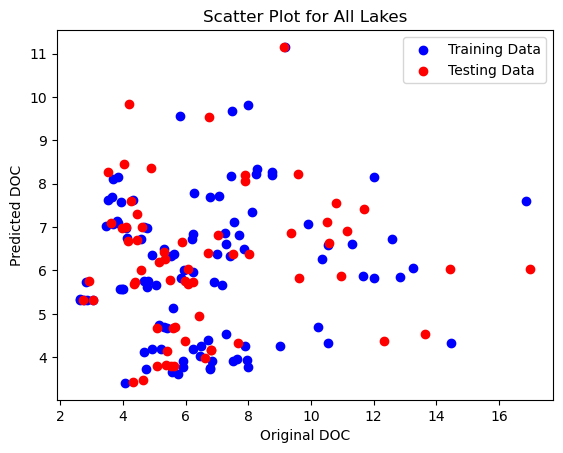

In [33]:
# Plot the scatter plot for all lakes combined
plt.scatter( data_train['original_DOC'],data_train['predicted_DOC'], color='blue', label='Training Data')
plt.scatter(data_test['original_DOC'],data_test['predicted_DOC'],  color='red', label='Testing Data')

# Set plot title and labels
plt.title('Scatter Plot for All Lakes')
plt.xlabel('Original DOC')
plt.ylabel('Predicted DOC')
plt.legend()

# Show the plot
plt.show()